In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
image_size = 64
batch_size = 64
num_epochs = 25
lr = 0.0002

# Transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Dataset
dataset = ImageFolder(root='D:/Researchwork24-25/work7/wood/wood/train', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
        nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),  # -> 4x4
        nn.BatchNorm2d(512), nn.ReLU(True),
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),         # -> 8x8
        nn.BatchNorm2d(256), nn.ReLU(True),
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),         # -> 16x16
        nn.BatchNorm2d(128), nn.ReLU(True),
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),          # -> 32x32
        nn.BatchNorm2d(64), nn.ReLU(True),
        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),            # -> 64x64
        nn.Tanh()
)
    def forward(self, z):
        return self.main(z)

# Encoder
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
        )
        self.fc = nn.Linear(512 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.encode(x)
        x = x.view(x.size(0), -1)
        return self.fc(x).view(-1, latent_dim, 1, 1)

# Discriminator with Adaptive Pooling
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1)  # Ensures 1x1 output
        )
        self.out = nn.Conv2d(512, 1, kernel_size=1)  # No sigmoid

    def forward(self, x):
        x = self.features(x)
        x = self.out(x)
        return x.view(-1)

# Initialize
G = Generator().to(device)
E = Encoder().to(device)
D = Discriminator().to(device)

loss_bce = nn.BCEWithLogitsLoss()  # More stable
loss_mse = nn.MSELoss()

optimizer_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_E = torch.optim.Adam(E.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        batch = imgs.size(0)
        valid = torch.ones(batch, device=device)
        fake = torch.zeros(batch, device=device)

        # Train Discriminator
        z = torch.randn(batch, latent_dim, 1, 1, device=device)
        gen_imgs = G(z)
        d_loss = loss_bce(D(imgs), valid) + loss_bce(D(gen_imgs.detach()), fake)

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        g_loss = loss_bce(D(gen_imgs), valid)
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Train Encoder
        z_enc = E(imgs)
        recon = G(z_enc)
        e_loss = loss_mse(recon, imgs)
        optimizer_E.zero_grad()
        e_loss.backward()
        optimizer_E.step()

    print(f"[{epoch+1}/{num_epochs}] D: {d_loss.item():.4f}, G: {g_loss.item():.4f}, E: {e_loss.item():.4f}")
    if (epoch+1) % 10 == 0:
        save_image(recon[:25], f"fanogan_epoch{epoch+1}.png", normalize=True, nrow=5)

# Save models
torch.save(G.state_dict(), "fanogan_G.pth")
torch.save(E.state_dict(), "fanogan_E.pth")
torch.save(D.state_dict(), "fanogan_D.pth")


[1/25] D: 1.3448, G: 0.7298, E: 0.3313
[2/25] D: 1.2361, G: 0.7706, E: 0.2771
[3/25] D: 1.0979, G: 0.8452, E: 0.1639
[4/25] D: 0.9766, G: 0.9258, E: 0.3495
[5/25] D: 0.9116, G: 0.9829, E: 0.2664
[6/25] D: 0.8106, G: 1.0803, E: 0.2289
[7/25] D: 0.9397, G: 1.0753, E: 0.1887
[8/25] D: 0.7583, G: 1.1529, E: 0.1890
[9/25] D: 0.7062, G: 1.1874, E: 0.1679
[10/25] D: 0.7334, G: 1.2664, E: 0.1451
[11/25] D: 0.6501, G: 1.3419, E: 0.1948
[12/25] D: 0.7061, G: 1.3417, E: 0.2164
[13/25] D: 0.8289, G: 1.4751, E: 0.1818
[14/25] D: 0.5591, G: 1.4373, E: 0.1551
[15/25] D: 0.5295, G: 1.4733, E: 0.1718
[16/25] D: 0.5693, G: 1.5229, E: 0.1974
[17/25] D: 0.5430, G: 1.5789, E: 0.1349
[18/25] D: 0.4124, G: 1.6483, E: 0.1198
[19/25] D: 0.4480, G: 1.6937, E: 0.1264
[20/25] D: 0.4209, G: 1.7722, E: 0.1336
[21/25] D: 0.4078, G: 1.8112, E: 0.1106
[22/25] D: 0.4168, G: 1.7937, E: 0.1901
[23/25] D: 0.5605, G: 1.8155, E: 0.1888
[24/25] D: 0.5020, G: 1.6724, E: 0.1429
[25/25] D: 0.4302, G: 1.8280, E: 0.1382


In [3]:
def detect_defect(test_img_path):
    G.eval()

    # Load and preprocess real test image
    img = Image.open(test_img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)  # Shape: [1, 3, 64, 64]

    best_score = -1
    best_z = None

    for _ in range(500):  # Try 500 latent vectors
        z = torch.randn(1, latent_dim, 1, 1, device=device)
        gen_img = G(z)  # Output: [1, 3, ?, ?]

        # Resize generated image to match test image size (e.g., 64x64)
        if gen_img.shape != img.shape:
            gen_img = torch.nn.functional.interpolate(
                gen_img, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
            )

        # Convert tensors to numpy for SSIM
        real_np = img.squeeze().permute(1, 2, 0).cpu().detach().numpy()
        fake_np = gen_img.squeeze().permute(1, 2, 0).cpu().detach().numpy()

        # Make sure they are the same shape for SSIM
        h = min(real_np.shape[0], fake_np.shape[0])
        w = min(real_np.shape[1], fake_np.shape[1])
        real_np = real_np[:h, :w, :]
        fake_np = fake_np[:h, :w, :]

        try:
            score = ssim(real_np, fake_np, channel_axis=2, data_range=2.0)
        except Exception as e:
            print(f"SSIM error on {test_img_path}: {e}")
            continue

        if score > best_score:
            best_score = score
            best_z = z

    best_fake = G(best_z)

    # Resize again to match before MSE
    if best_fake.shape != img.shape:
        best_fake = torch.nn.functional.interpolate(
            best_fake, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
        )

    # Compute MSE
    mse = torch.mean((img - best_fake) ** 2).item()

    # Print results
    print(f"\nImage: {test_img_path}")
    print(f"MSE: {mse:.4f}, SSIM: {best_score:.4f}")
    if mse > 0.1 or best_score < 0.6:
        print("⚠️ Defect Detected")
    else:
        print("✅ No Defect Detected")

    return img, best_fake

In [4]:
detect_defect("D:\\Researchwork24-25\\work7\\wood\\wood\\test\\hole\\000.png")


Image: D:\Researchwork24-25\work7\wood\wood\test\hole\000.png
MSE: 0.1703, SSIM: 0.0107
⚠️ Defect Detected


(tensor([[[[ 0.2471,  0.3098,  0.4118,  ...,  0.3333,  0.2235,  0.2157],
           [ 0.2863,  0.3412,  0.4510,  ...,  0.3725,  0.2706,  0.2706],
           [ 0.3412,  0.4196,  0.4902,  ...,  0.4039,  0.3020,  0.3333],
           ...,
           [ 0.4824,  0.4275,  0.3176,  ...,  0.2863,  0.2549,  0.2941],
           [ 0.4667,  0.4510,  0.3176,  ...,  0.2627,  0.2471,  0.2627],
           [ 0.4118,  0.4196,  0.3098,  ...,  0.2549,  0.2000,  0.2157]],
 
          [[-0.1373, -0.0902, -0.0353,  ..., -0.0667, -0.1529, -0.1686],
           [-0.1137, -0.0745, -0.0118,  ..., -0.0510, -0.1216, -0.1373],
           [-0.0667, -0.0196,  0.0275,  ..., -0.0275, -0.0980, -0.0745],
           ...,
           [ 0.0824,  0.0196, -0.0510,  ..., -0.0745, -0.1137, -0.0745],
           [ 0.0824,  0.0353, -0.0588,  ..., -0.0980, -0.1137, -0.0902],
           [ 0.0431,  0.0196, -0.0588,  ..., -0.1137, -0.1608, -0.1294]],
 
          [[-0.3333, -0.3098, -0.2706,  ..., -0.3020, -0.3569, -0.3804],
           [-

In [13]:
import os
import glob
import pandas as pd
from PIL import Image
import torch
from skimage.metrics import structural_similarity as ssim

def batch_test_analysis(test_folder):
    records = []

    for class_folder in os.listdir(test_folder):
        class_path = os.path.join(test_folder, class_folder)
        if not os.path.isdir(class_path):
            continue

        for img_file in glob.glob(os.path.join(class_path, "*.png")):
            try:
                G.eval()
                img = Image.open(img_file).convert("RGB")
                img = transform(img).unsqueeze(0).to(device)

                best_score = -1
                best_z = None

                for _ in range(200):
                    z = torch.randn(1, latent_dim, 1, 1, device=device)
                    gen_img = G(z)

                    # Resize generated image to match original if needed
                    if gen_img.shape != img.shape:
                        gen_img = torch.nn.functional.interpolate(
                            gen_img, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
                        )

                    # Convert tensors to NumPy
                    real_np = img.squeeze().permute(1, 2, 0).cpu().detach().numpy()
                    fake_np = gen_img.squeeze().permute(1, 2, 0).cpu().detach().numpy()

                    # Ensure equal size for SSIM
                    h = min(real_np.shape[0], fake_np.shape[0])
                    w = min(real_np.shape[1], fake_np.shape[1])
                    real_np = real_np[:h, :w, :]
                    fake_np = fake_np[:h, :w, :]

                    score = ssim(real_np, fake_np, channel_axis=2, data_range=2.0)

                    if score > best_score:
                        best_score = score
                        best_z = z

                best_fake = G(best_z)

                # Resize best_fake if needed
                if best_fake.shape != img.shape:
                    best_fake = torch.nn.functional.interpolate(
                        best_fake, size=(img.shape[2], img.shape[3]), mode='bilinear', align_corners=False
                    )

                mse = torch.mean((img - best_fake) ** 2).item()

                records.append({
                    "class": class_folder,
                    "image": os.path.basename(img_file),
                    "mse": mse,
                    "ssim": best_score
                })

                print(f"Processed: {img_file}")

            except Exception as e:
                print(f"Error on {img_file}: {e}")

    df = pd.DataFrame(records)
    df.to_csv("defect_detection_stats4.csv", index=False)
    print("\n✅ Saved results to 'defect_detection_stats.csv'")
    return df


In [ ]:
# Example usage:
test_path = r'D:\Researchwork24-25\work7\wood\wood\test'
df_stats = batch_test_analysis(test_path)
df_stats.to_csv("defect_detection_stats4.csv", index=False)
print(df_stats.head())

Processed: D:\Researchwork24-25\work7\wood\wood\test\color\000.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\001.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\002.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\003.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\004.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\005.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\006.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\color\007.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\000.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\001.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\002.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\003.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\004.png
Processed: D:\Researchwork24-25\work7\wood\wood\test\combined\005.png
Processed: D:\Researchwork24-25\work7\wood\w

In [ ]:
print(df_stats.groupby("class")[["mse", "ssim"]].agg(["mean", "std"]))

               mse                ssim          
              mean       std      mean       std
class                                           
color     0.171328  0.020847  0.009531  0.009416
combined  0.166402  0.021121  0.010066  0.007813
good      0.162792  0.017314  0.011017  0.004201
hole      0.167691  0.022385  0.010316  0.003850
liquid    0.162998  0.010239  0.011135  0.006337
scratch   0.167128  0.021607  0.007602  0.007648


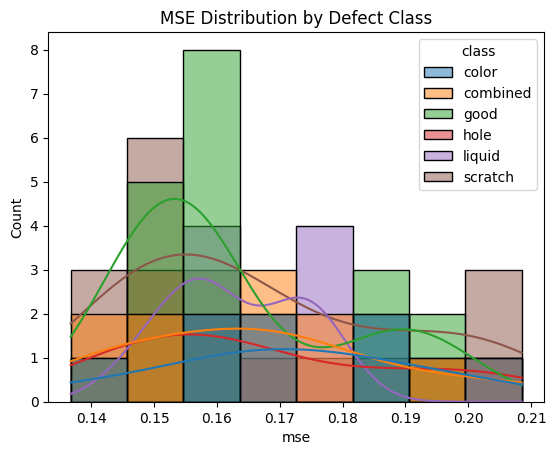

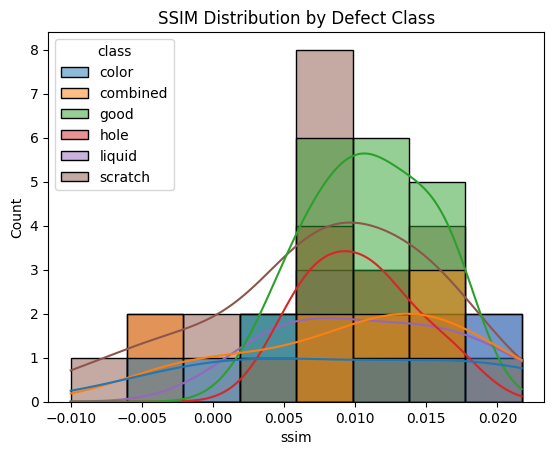

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_stats, x="mse", hue="class", kde=True)
plt.title("MSE Distribution by Defect Class")
plt.show()

sns.histplot(data=df_stats, x="ssim", hue="class", kde=True)
plt.title("SSIM Distribution by Defect Class")
plt.show()

In [ ]:
df_stats["label"] = df_stats["class"].apply(lambda x: 0 if x == "good" else 1)

ROC AUC (MSE as score): 0.5728


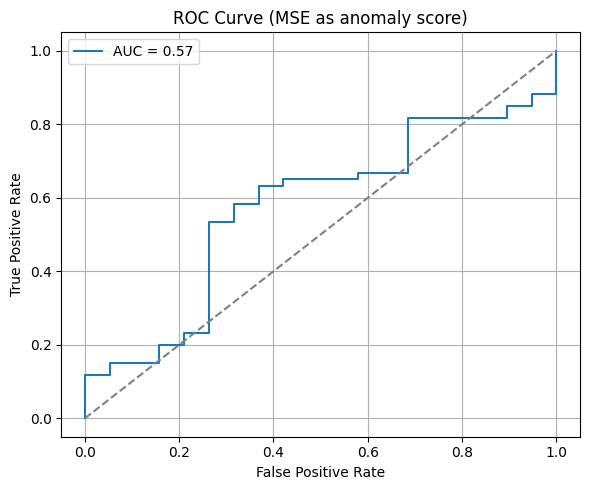

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# ROC AUC using MSE as score
# -----------------------------
y_true = df_stats["label"]
y_score = df_stats["mse"]  # Use "ssim" if preferred (inverted)

auc_score = roc_auc_score(y_true, y_score)
print(f"ROC AUC (MSE as score): {auc_score:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (MSE as anomaly score)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
import matplotlib.pyplot as plt

def evaluate_map_ganomaly(y_true, y_score):
    # y_true: list of 0 (normal) or 1 (defect)
    # y_score: corresponding anomaly scores

    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    auc_score = auc(recall, precision)

    # Plot PR curve
    plt.plot(recall, precision, label=f"mAP (AP): {ap:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Mean Average Precision (mAP/AP): {ap:.4f}")
    print(f"AUC under PR curve: {auc_score:.4f}")
    return ap

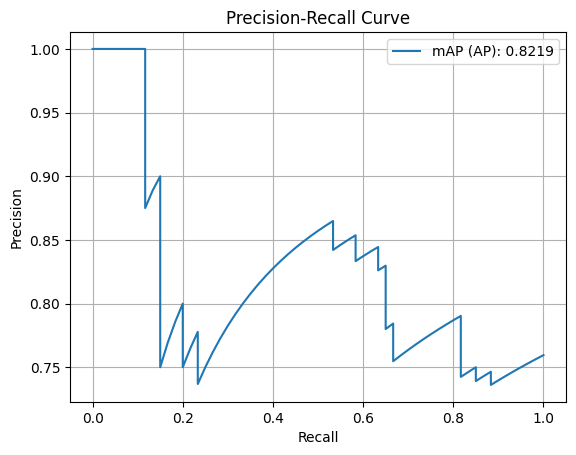

Mean Average Precision (mAP/AP): 0.8219
AUC under PR curve: 0.8192


0.8219449846216343

In [12]:
evaluate_map_ganomaly(y_true, y_score)